## Импорты

In [72]:
import importlib
import sys
import warnings

# в режиме редактирования сбрасуем кэшь иначе не видно изменений
for module in [
    "utils" 
]:
    imported_module = importlib.import_module(module)
    importlib.reload(imported_module)

from utils import predict_and_accuracy, plot_models, get_coordianates_griid_2D, get_grid_2D

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import pandas as pd

# Импорт библиотек
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Всё, что выводит CUDA / XLA, будет записано в файл
sys.stderr = open("xla_warnings.log", "w")
warnings.filterwarnings("ignore")

## Данные

In [27]:
# === 1. Загружаем данные ===
iris = load_iris()
X = iris.data[:, :2] # Берем 2 признака, чтобы можно было визуализировать и эти два признака менее информативны
                     # что дает более правдоподобный резальтат при обучении с малым колличеством данных
y = iris.target
# === 2. Разделяем на train/test ===
X_train, X_test, y_train, y_test = train_test_split(
 X, y, test_size=0.3, random_state=42, stratify=y
)

## Модели

In [21]:
# Инициализация моделей
models = {
 "Линейная регрессия": LinearRegression(),
 "Логистическая регрессия": LogisticRegression(max_iter=500),
 "SVM": SVC(kernel='linear'),
 "Нейронная сеть": MLPClassifier(hidden_layer_sizes=(5,), max_iter=1000),
 "Байес (Naive Bayes)": GaussianNB(),
 "Дерево решений": DecisionTreeClassifier(max_depth=3, random_state=42),
 "Gradient Boosting": GradientBoostingClassifier(
     n_estimators=50, # 100
     learning_rate=0.1, max_depth=3, random_state=42
 ),
  "XGBoost": XGBClassifier(
     n_estimators=50, # 100
     learning_rate=0.1,
     max_depth=3,
     use_label_encoder=False,
     # subsample=0.8, # доля данных для каждого дерева
     # colsample_bytree=0.8, # доля признаков для каждого дерева
     eval_metric="mlogloss",
     verbosity=0,
     random_state=42,
 ),
 "LightGBM": LGBMClassifier(
     n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42, verbosity=0,
 ),
 "CatBoost": CatBoostClassifier(
     n_estimators=50, learning_rate=0.1, depth=3, random_state=42
 ),
 "KNN": KNeighborsClassifier(n_neighbors=3)
}

In [57]:
# Обучаем все модели
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    info = {"Модель": name}
    # Проверяем, есть ли веса
    if hasattr(model, "coef_"):
        info["Есть веса?"] = "✅ Да"
        info["Пример весов"] = model.coef_[:3] # первые 3 для краткости
    elif hasattr(model, "feature_importances_"):
        info["Есть веса?"] = "⚙️ Косвенно (важности признаков)"
        info["Пример весов"] = model.feature_importances_[:3]
    elif hasattr(model, "coefs_"):  # <── добавляем это
        info["Есть веса?"] = "✅ Да (нейронная сеть)"
        info["Пример весов"] = [w.shape for w in model.coefs_]
    else:
        info["Есть веса?"] = "❌ Нет"
        info["Пример весов"] = "-"
    print(model)
    info["Точность одного дерева"] = predict_and_accuracy(model, X_test,  y_test)
    results.append(info)

LinearRegression()
LogisticRegression(max_iter=500)
SVC(kernel='linear')
MLPClassifier(hidden_layer_sizes=(5,), max_iter=1000)
GaussianNB()
DecisionTreeClassifier(max_depth=3, random_state=42)
GradientBoostingClassifier(n_estimators=50, random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              

In [58]:
# В таблицу
df = pd.DataFrame(results)
display(df)

,Модель,Есть веса?,Пример весов,Точность одного дерева
0,Линейная регрессия,✅ Да,"[0.7381047288017997, -0.536274651146294]",0.733333
1,Логистическая регрессия,✅ Да,"[[-2.5571444610851373, 1.8272952666179785], [0...",0.733333
2,SVM,✅ Да,"[[-2.1633690742307685, 1.6217842116062293], [-...",0.711111
3,Нейронная сеть,✅ Да (нейронная сеть),"[(2, 5), (5, 3)]",0.088889
4,Байес (Naive Bayes),❌ Нет,-,0.688889
5,Дерево решений,⚙️ Косвенно (важности признаков),"[0.8195872391368375, 0.18041276086316252]",0.733333
6,Gradient Boosting,⚙️ Косвенно (важности признаков),"[0.7296577806473813, 0.27034221935261865]",0.711111
7,XGBoost,⚙️ Косвенно (важности признаков),"[0.6406642, 0.3593358]",0.688889
8,LightGBM,⚙️ Косвенно (важности признаков),"[232, 221]",0.688889
9,CatBoost,⚙️ Косвенно (важности признаков),"[69.76805097024264, 30.231949029757377]",0.777778


In [59]:
# === 4. Обучаем и собираем результаты
results = {}
for name, model in models.items():
 model.fit(X_train, y_train)
 acc = model.score(X_test, y_test)
 results[name] =  (model, acc)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [67]:
xx, yy = get_coordianates_griid_2D(X)

In [68]:
# === 5. Визуализация границ ===
grid = get_grid_2D(X, xx, yy)

✅ График сохранён в файл: models_summary.png


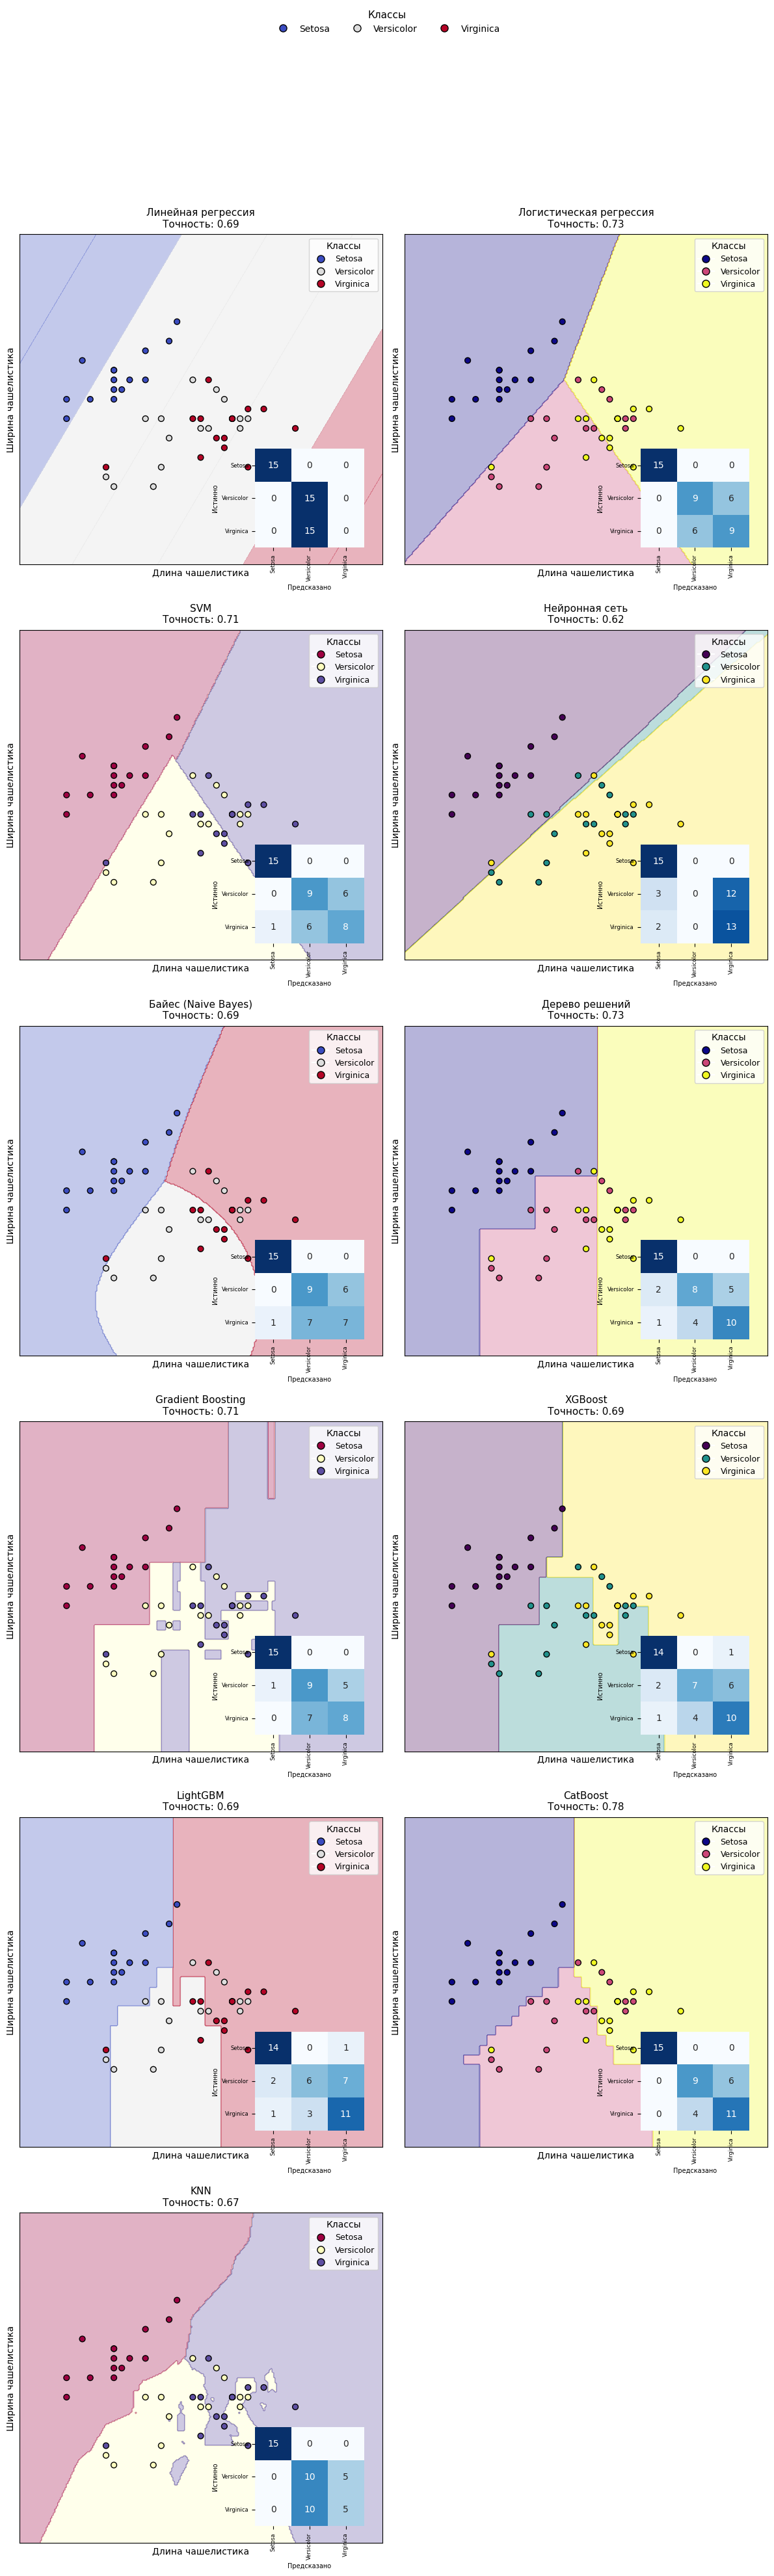

In [73]:
plot_models(
    results,
    X_test, y_test, X, xx, yy, grid,
    feature_names=("Длина чашелистика", "Ширина чашелистика"),
    cmaps=["coolwarm", "plasma", "Spectral", "viridis"],
    class_names=["Setosa", "Versicolor", "Virginica"],
    save_path="models_summary.png",
    dpi=400,
    show_legend=True,         # ✅ общая легенда сверху
    per_plot_legend=True,     # ✅ локальные легенды для каждого графика
    show_confusion=True       # ✅ показывать confusion matrix в каждом окне
)